In [238]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tqdm as tqdm
import Utils

import tensorflow as tf
import tensorflow 

from tensorflow import keras
from keras import backend as K
from keras import layers
from keras.regularizers import l2
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import tensorflow_addons as tfa


In [195]:
def load_data(surface_path, target_path):
    targets = pd.read_csv(target_path, skiprows=2, parse_dates=True, index_col=0)
    targets = pd.DataFrame(targets['Close'])

    surfaces = pd.read_csv(surface_path, parse_dates=True, index_col=[0,1])

    dates = surfaces.index.get_level_values(0).unique()
    dates = pd.Series(list(set(targets.index).intersection(set(dates))))
    dates = dates.sort_values()


    targets = targets.loc[dates]
    surfaces = surfaces.loc[dates]
    return surfaces, targets

def target_volatility(surfaces, targets):
    rets = Utils.convert_to_daily_returns(targets)
    volatility = rets.rolling(window=252).std()*np.sqrt(252)
    dates = volatility.dropna().index
    return surfaces.loc[dates], volatility.dropna()


def stack_days(surfaces, targets, stacks):

    dim = len(surfaces.index.get_level_values(0).unique())
    dim1 = len(surfaces.index.get_level_values(1).unique())

    surfaces_np = surfaces.values.reshape((dim, dim1, surfaces.shape[1]))

    stacked_surfaces = np.zeros((len(surfaces_np)-stacks, dim1, surfaces.shape[1], stacks))
    
    for i in range(len(surfaces_np)-stacks):
        temp = np.stack(surfaces_np[i:i+stacks]).transpose(1,2,0)
        stacked_surfaces[i] = temp

    stacked_dates = surfaces.index.get_level_values(0).unique()[stacks:]
    
    return stacked_surfaces, targets.loc[stacked_dates], stacked_dates


def lag_targets(surfaces, targets, lag, dates):
    lagged = targets.shift(-lag)
    return surfaces[:-lag], lagged.dropna(), dates[lag:]


def train_test_split(test_start, test_end, dates, surfaces, targets):
    test_dates = pd.Series(dates, index=dates)[test_start:test_end]
    
    start_ind = dates.get_loc(test_dates.iloc[0])
    end_ind = dates.get_loc(test_dates.iloc[-1]) + 1
        
    surfaces_test = surfaces[start_ind:end_ind]
    targets_test = targets.to_numpy()[start_ind:end_ind]
    
    surfaces_train = surfaces[:start_ind]
    surfaces_train = np.concatenate((surfaces_train,surfaces[end_ind:]))

    targets_train = targets.to_numpy()[:start_ind]
    targets_train = np.concatenate((targets_train,targets.to_numpy()[end_ind:]))
    
    train_dates = pd.Series(dates, index=dates).loc[~pd.Series(dates, index=dates).index.isin(test_dates)].index
    
    return surfaces_train, surfaces_test, targets_train, targets_test, train_dates, test_dates
    
    
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [228]:
surfaces, targets = load_data("processed_data/SPX.csv", "data/SPX.csv")

surfaces, targets = target_volatility(surfaces, targets)

stacked_surfaces, stacked_targets, dates = stack_days(surfaces, targets, 10)

stacked_surfaces, stacked_targets_lagged, dates = lag_targets(stacked_surfaces, stacked_targets, 1, dates)

surfaces_train, surfaces_test, targets_train, targets_test, train_dates, test_dates = train_test_split('2019', '2023', dates, stacked_surfaces, stacked_targets_lagged)

input_shape = surfaces_train[0].shape

In [229]:
model = keras.models.Sequential()

model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=l2(0.0001), activation='relu', input_shape=input_shape, padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=l2(0.0001), activation='relu', input_shape=input_shape, padding='same'))
model.add(layers.Conv2D(128, (3, 3), kernel_regularizer=l2(0.0001), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), kernel_regularizer=l2(0.0001), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


#model.add(layers.BatchNormalization())


model.add(layers.Flatten())

model.add(layers.Dense(256, kernel_regularizer=l2(0.0001), activation='relu'))

model.add(layers.Dense(128, kernel_regularizer=l2(0.0001), activation='relu'))
#model.add(layers.Dropout(0.1))

model.add(layers.Dense(64, kernel_regularizer=l2(0.0001), activation='relu'))

model.add(layers.Dense(1, activation='linear'))

In [252]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.Huber(),
              metrics=[r_square, tf.keras.losses.Huber()])

K.set_value(model.optimizer.learning_rate, 0.005)

history = model.fit(surfaces_train, targets_train, epochs=50, batch_size=64)



Epoch 1/50
87/87 [==============================] - 6s 59ms/step - loss: 6.4586e-04 - r_square: 0.8411 - huber_loss: 4.0723e-04
Epoch 2/50
87/87 [==============================] - 5s 54ms/step - loss: 7.3314e-04 - r_square: 0.8092 - huber_loss: 5.0151e-04
Epoch 3/50
87/87 [==============================] - 5s 56ms/step - loss: 6.0419e-04 - r_square: 0.8537 - huber_loss: 3.8806e-04
Epoch 4/50
87/87 [==============================] - 5s 60ms/step - loss: 6.5369e-04 - r_square: 0.8317 - huber_loss: 4.2606e-04
Epoch 5/50
87/87 [==============================] - 5s 61ms/step - loss: 6.0784e-04 - r_square: 0.8480 - huber_loss: 4.0107e-04
Epoch 6/50
87/87 [==============================] - 6s 68ms/step - loss: 7.0432e-04 - r_square: 0.8152 - huber_loss: 4.8532e-04
Epoch 7/50
87/87 [==============================] - 6s 64ms/step - loss: 6.1299e-04 - r_square: 0.8392 - huber_loss: 4.1025e-04
Epoch 8/50
87/87 [==============================] - 6s 70ms/step - loss: 5.8883e-04 - r_square: 0.8506 -

24/24 - 1s - loss: 0.0093 - r_square: -3.5435e+04 - huber_loss: 0.0090 - 511ms/epoch - 21ms/step


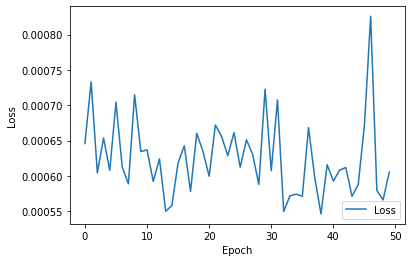

In [253]:
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

test_loss = model.evaluate(surfaces_test,  targets_test, verbose=2)

In [254]:
def plot_train_fit(surfaces_train, targets_train, dates_train):
        
    preds = model.predict(surfaces_train)
    print('R2: ')
    print(r2_score(targets_train, preds))
    print()
    
    print('MSE: ')
    print(mean_squared_error(targets_train, preds))
    
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 10)
    plt.plot(dates_train, targets_train, label='Realized')
    plt.plot(dates_train, preds, label='Model')
    plt.legend()

R2: 
0.34265715599836255

MSE: 
0.0037825717703164185


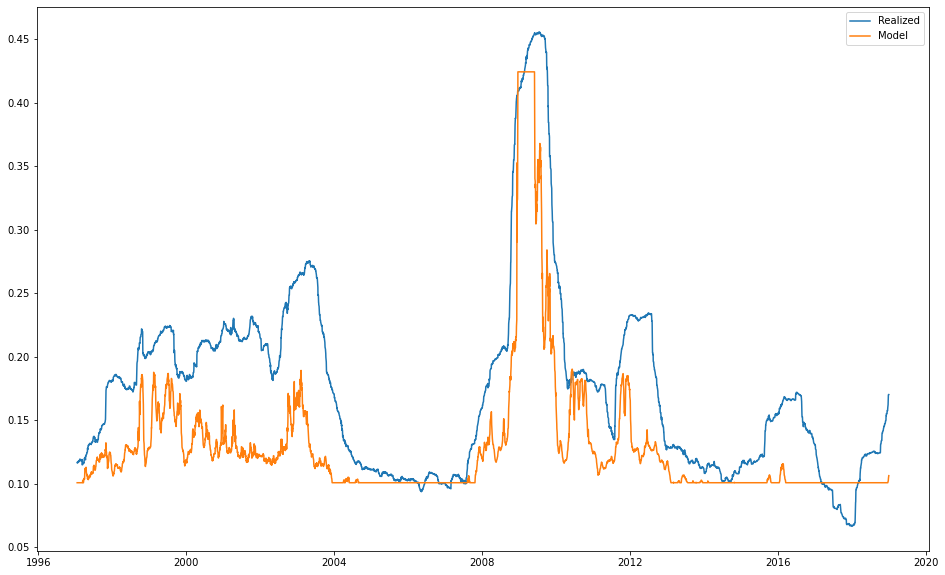

In [255]:
plot_train_fit(surfaces_train, targets_train, train_dates)

R2: 
-1.4148952015862135

MSE: 
0.018178140020736835


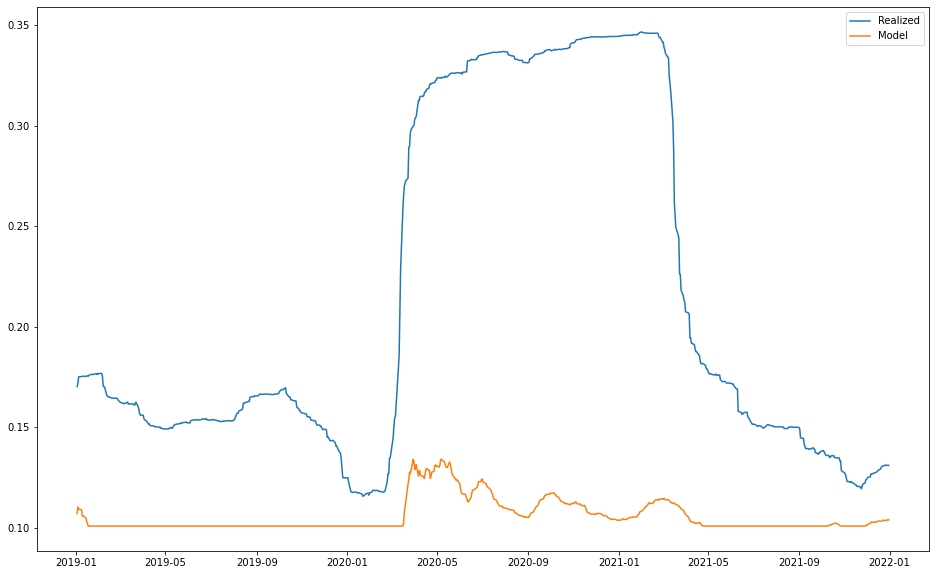

In [256]:
plot_train_fit(surfaces_test, targets_test, test_dates)